**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 8: Principal Component Analysis (PCA)

## Set-up the analysis environment

In [7]:
library(tidyverse)
library(vegan)
library(GGally)
library(cluster)
library(purrr)
library(dendextend)
library(ggcorrplot)
library(DataExplorer)
library(factoextra)
library(gridExtra)

Loading required package: permute


Attaching package: ‘permute’


The following object is masked from ‘package:dendextend’:

    shuffle


Loading required package: lattice

Registered S3 method overwritten by 'vegan':
  method     from      
  rev.hclust dendextend

This is vegan 2.5-7



## Country data

Data taken from a [Kaggle challenge](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data). Information about the data and the analysis is repeated here almost verbatim, but I have included various edits and modifications to the analysis.

### Clustering the Countries by using Unsupervised Learning for HELP International
#### Objective
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

#### About organization
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

#### Problem Statement
HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

### Load the data and examine it

In [20]:
data <- read_csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/_GitBook/data/Country-data.csv")
head(data)
summary(data)


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  country = col_character(),
  child_mort = col_double(),
  exports = col_double(),
  health = col_double(),
  imports = col_double(),
  income = col_double(),
  inflation = col_double(),
  life_expec = col_double(),
  total_fer = col_double(),
  gdpp = col_double()
)




country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300


   country            child_mort        exports            health      
 Length:167         Min.   :  2.60   Min.   :  0.109   Min.   : 1.810  
 Class :character   1st Qu.:  8.25   1st Qu.: 23.800   1st Qu.: 4.920  
 Mode  :character   Median : 19.30   Median : 35.000   Median : 6.320  
                    Mean   : 38.27   Mean   : 41.109   Mean   : 6.816  
                    3rd Qu.: 62.10   3rd Qu.: 51.350   3rd Qu.: 8.600  
                    Max.   :208.00   Max.   :200.000   Max.   :17.900  
    imports             income         inflation         life_expec   
 Min.   :  0.0659   Min.   :   609   Min.   : -4.210   Min.   :32.10  
 1st Qu.: 30.2000   1st Qu.:  3355   1st Qu.:  1.810   1st Qu.:65.30  
 Median : 43.3000   Median :  9960   Median :  5.390   Median :73.10  
 Mean   : 46.8902   Mean   : 17145   Mean   :  7.782   Mean   :70.56  
 3rd Qu.: 58.7500   3rd Qu.: 22800   3rd Qu.: 10.750   3rd Qu.:76.80  
 Max.   :174.0000   Max.   :125000   Max.   :104.000   Max.   :82.80  

We can see that there are no missing values. Here's another way to look for missing values:

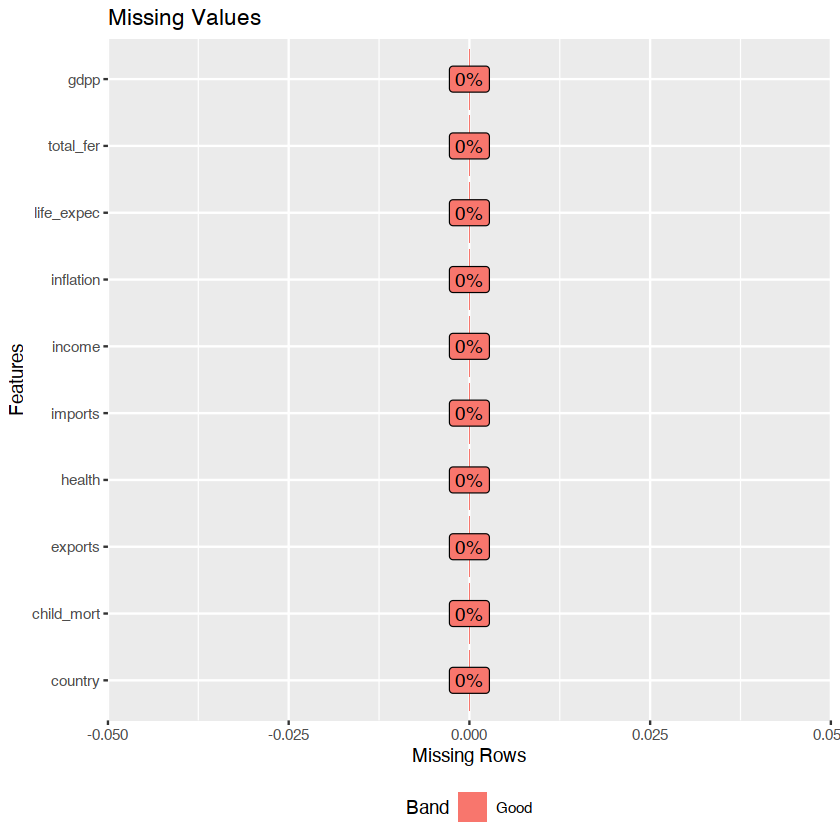

In [5]:
plot_missing(
    data, 
    title = "Missing Values"
)

The meaning of the column names are provided in a separate file:

In [6]:
read_csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/_GitBook/data/data-dictionary.csv")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  `Column Name` = col_character(),
  Description = col_character()
)




Column Name,Description
<chr>,<chr>
country,Name of the country
child_mort,Death of children under 5 years of age per 1000 live births
exports,Exports of goods and services per capita. Given as %age of the GDP per capita
health,Total health spending per capita. Given as %age of GDP per capita
imports,Imports of goods and services per capita. Given as %age of the GDP per capita
Income,Net income per person
Inflation,The measurement of the annual growth rate of the Total GDP
life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.


The Kaggle solution provides a pairwise correlation amongst variables, and I think this is a good idea:

## A pairwise correlation

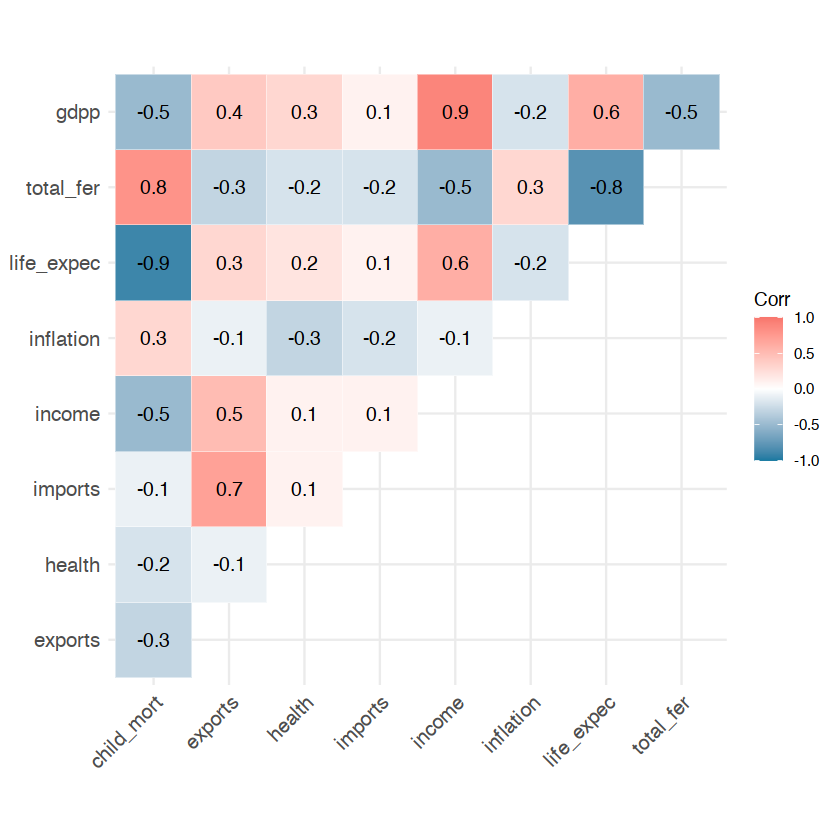

In [17]:
# computing a correalation matrix
corr <- round(cor(data[2:10]), 1)

# visualization of the correlation matrix
ggcorrplot(corr, type = 'upper', outline.col = "white",
          colors = c("#1679a1", "white", "#f8766d"),
          lab = TRUE)

## Do the PCA

At this point my analysis starts to deviate from the one set of solutions provided on Kaggle.

Because the data are in different units we standardise it first:

In [11]:
data_std <- decostand(data[, 2:10], method = "standardize")

Now we do the PCA using **vegan**'s `rda()`:

In [14]:
data_pca <- rda(data_std)
# summary(data_pca) # a very long list printed out, so I extract shorter components, below...

# the eigenvalues
eigenvals(data_pca)

# species scores
scores(data_pca, choices = c(1, 2, 3), display = "sp")

# site scores
head(scores(data_pca, choices = c(1, 2, 3), display = "sites"))


     PC1      PC2      PC3      PC4      PC5      PC6      PC7      PC8 
4.135657 1.546346 1.170383 0.994785 0.660619 0.223581 0.113439 0.088315 
     PC9 
0.066875 

,PC1,PC2,PC3
child_mort,-1.7680345,-0.49706804,0.06623580
exports,1.1964634,-1.58014181,-0.32454962
health,0.6356951,0.62644236,1.33763388
imports,0.6805561,-1.73130316,0.67242778
income,1.6792013,-0.05807478,-0.67606147
inflation,-0.8141134,0.02165859,-1.44051165
life_expec,1.7946694,0.57392236,-0.25540234
total_fer,-1.7014866,-0.40004065,-0.04382889
gdpp,1.6547733,0.11860118,-0.27571226


,PC1,PC2,PC3
sit1,-0.689130275,-0.03699367,0.3193460
sit2,0.101703540,0.22754554,0.1483004
sit3,-0.067475310,0.17609778,-0.5432010
sit4,-0.693719249,-0.65597597,-0.6781842
sit5,0.244511641,-0.05287049,0.1003777
sit6,0.005300855,0.68833131,-0.3868861


The percent inertia explained by the first three axes is:

In [18]:
round(sum(eigenvals(data_pca)[1:3]) / sum(eigenvals(data_pca)) * 100, 1)

[1] 76.1

## Ordination diagrams

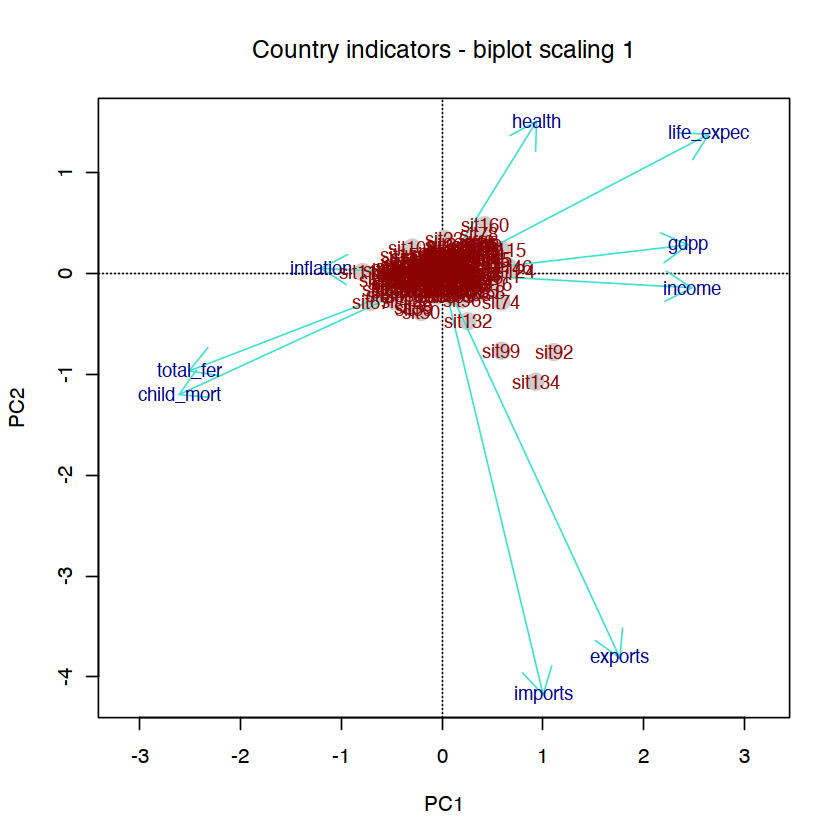

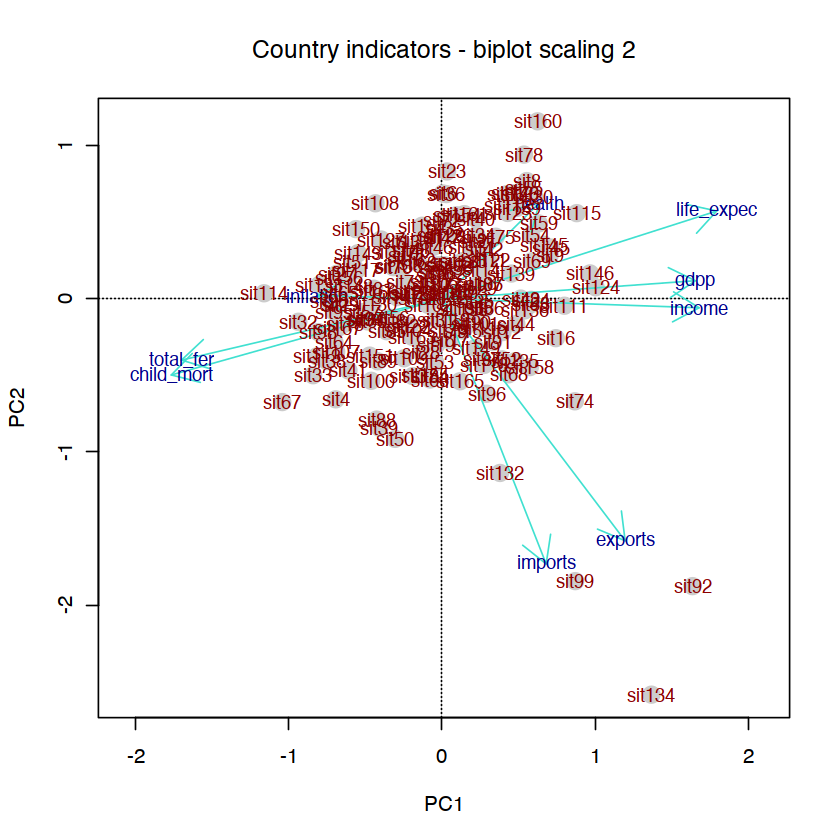

In [19]:
pl1 <- ordiplot(data_pca, type = "none", scaling = 1, main = "Country indicators - biplot scaling 1")
points(pl1, "sites", pch = 21, cex = 1.75, col = "grey80", bg = "grey80")
points(pl1, "species", pch = 21, col = "turquoise", arrows = TRUE)
text(pl1, "species", col = "blue4", cex = 0.9)
text(pl1, "sites", col = "red4", cex = 0.9)

pl2 <- ordiplot(data_pca, type = "none", scaling = 2, main = "Country indicators - biplot scaling 2")
points(pl2, "sites", pch = 21, cex = 1.75, col = "grey80", bg = "grey80")
points(pl2, "species", pch = 21, col = "turquoise", arrows = TRUE)
text(pl2, "species", col = "blue4", cex = 0.9)
text(pl2, "sites", col = "red4", cex = 0.9)